In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

import scipy.stats as stats
from scipy import special

# EDA
각 column들은 사용자 정의 기능을 나타내는 익명화된 변수

## train

In [152]:
benz= pd.read_csv('./Data/benz/train.csv')
benz.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [153]:
# train data의 결측치 확인
benz.isnull().sum().sum()

0

In [154]:
# 각 columns들의 type 확인
benz.drop('y',axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 377 entries, ID to X385
dtypes: int64(369), object(8)
memory usage: 12.1+ MB


skew : 1.2060958289669412, kurtosis : 7.899893252938124


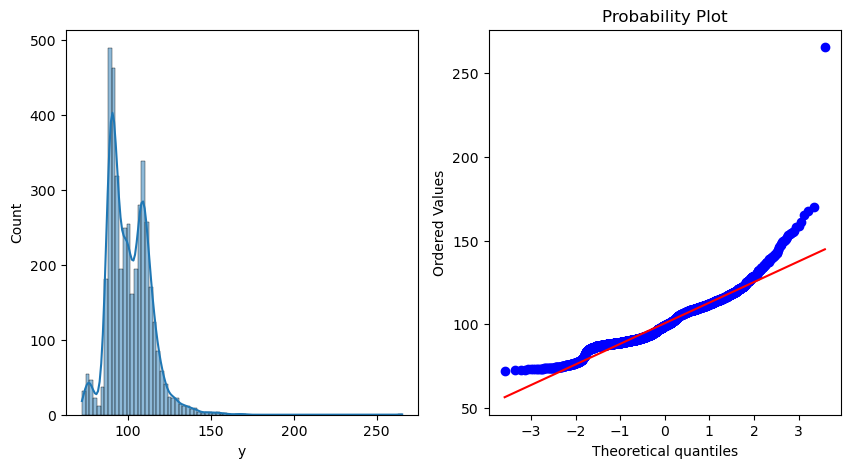

In [155]:
fig, axs = plt.subplots(figsize = (10, 5), nrows=1, ncols=2)

# target의 분포 확인
print(f'skew : {stats.skew(benz["y"])}, kurtosis : {stats.kurtosis(benz["y"])}')

sns.histplot(benz['y'], kde=True, ax=axs[0])

stats.probplot(benz['y'], dist='norm',plot=axs[1])

plt.show()

skew : 0.39502172187878937, kurtosis : 1.3237908895118338


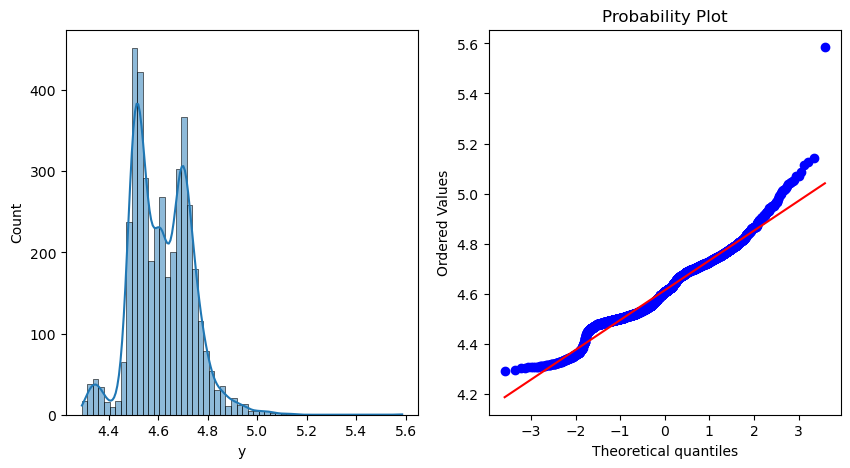

In [156]:
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

# log 변환한 target의 분포 확인
print(f'skew : {stats.skew(np.log1p(benz["y"]))}, kurtosis : {stats.kurtosis(np.log1p(benz["y"]))}')

sns.histplot(np.log1p(benz['y']), kde=True, ax=axs[0])

stats.probplot(np.log1p(benz['y']), dist="norm", plot=axs[1])

plt.show()

box-cox   

$\frac{x^λ-1}{λ}$&ensp;(λ != 0 )  
$lnx$&ensp;(λ =  0)

skew : -0.015529542964082602, kurtosis : 0.3999683390293707


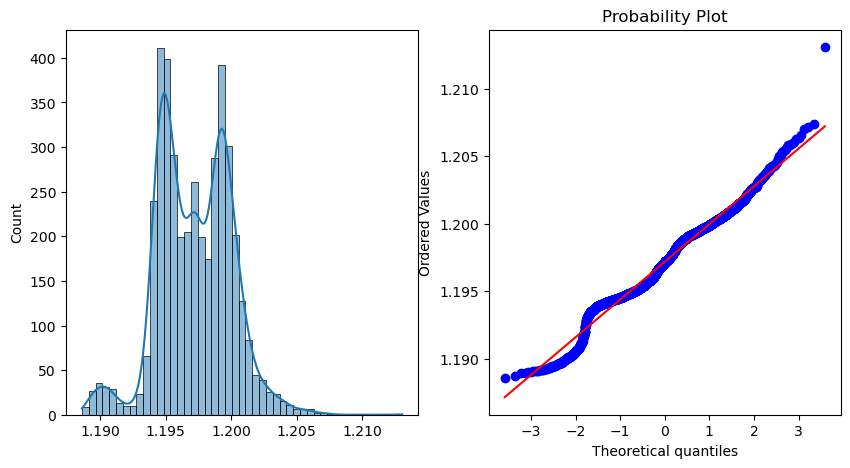

In [157]:
fig, axs  = plt.subplots(figsize = (10,5), nrows=1, ncols=2)

# box-cox 변환한 target의 분포 확인
transformed, lambda_ = stats.boxcox(benz['y'])

print(f'skew : {stats.skew(transformed)}, kurtosis : {stats.kurtosis(transformed)}')

sns.histplot(transformed, kde=True, ax=axs[0])

stats.probplot(transformed, dist="norm", plot=axs[1])

plt.show()



In [158]:
# type이 object인 column 추출 (8개)
object_columns = benz.loc[:, benz.dtypes == object].columns

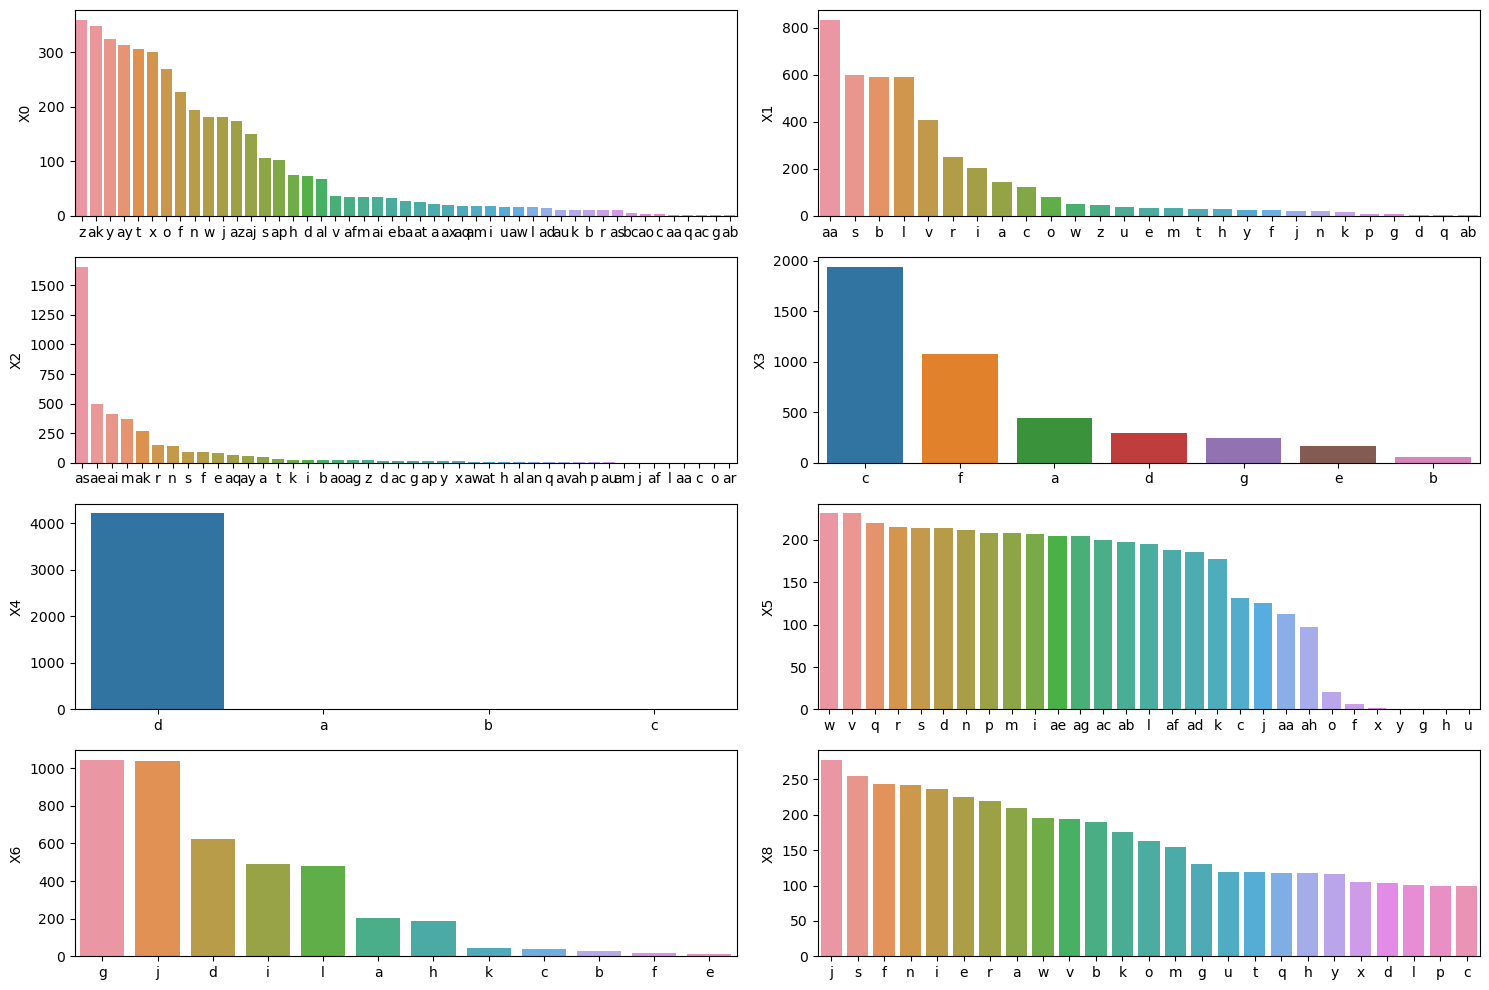

In [159]:
# object type의 column들의 value count
ncol = 2

if len(object_columns)%2 == 0:
    nrow = int(len(object_columns)/2)
else:
    nrow = int(len(object_columns)/2) + 1

fig, axs = plt.subplots(figsize = (15,10),nrows = nrow ,ncols=ncol)

for seq in range(len(object_columns)):
    row = int(seq/ncol)
    col = seq % ncol

    sns.barplot(x=benz[object_columns[seq]].value_counts().index, y=benz[object_columns[seq]].value_counts(), ax=axs[row, col])

plt.tight_layout()

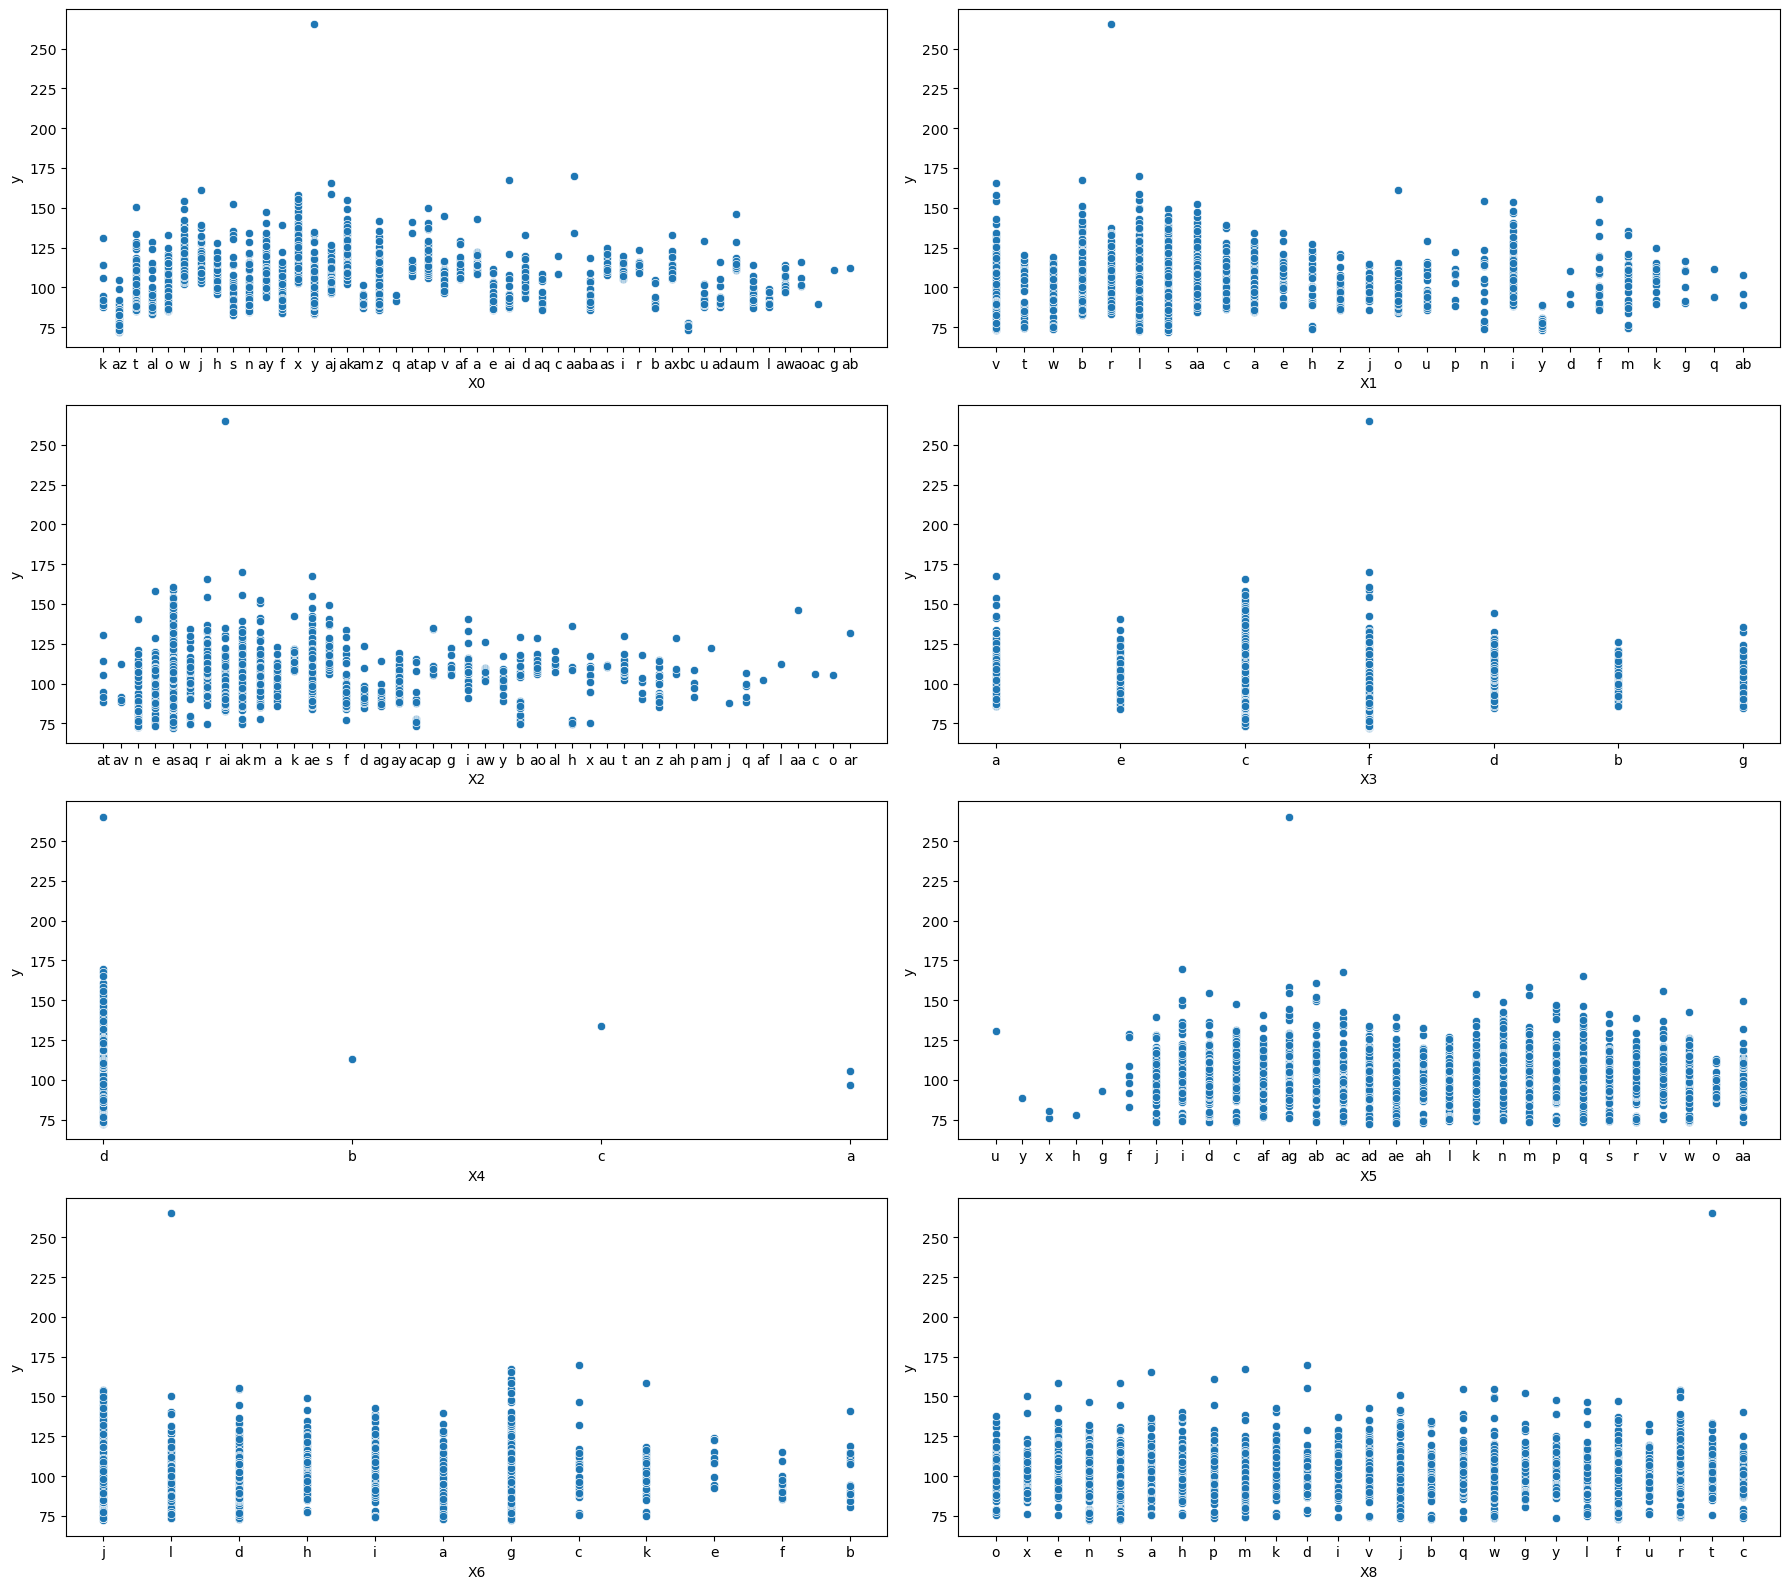

In [160]:
# obect column들에 따른 target값 확인
fig, axs = plt.subplots(figsize = (18,16), nrows=nrow, ncols=ncol)

for seq in range(len(object_columns)):
    row = int(seq/ncol)
    col = seq%ncol
    
    sns.scatterplot(x=benz[object_columns[seq]], y=benz['y'], ax=axs[row, col])

plt.tight_layout()

In [161]:
# type이 int인 column 추출 (369개)
int_columns = benz.loc[:, benz.dtypes == 'int64'].columns

zero_col = list()
cont_col = list()
cate_col = list()

for col in int_columns:
    if len(benz[col].unique()) == 1:
        zero_col.append(col)
    elif len(benz[col].unique()) == 2:
        cate_col.append(col)
    else:
        cont_col.append(col)

print(cont_col)
print(zero_col)

print(f'category count : {len(cate_col)}, continuous count : {len(cont_col)}, one value count : {len(zero_col)}')

['ID']
['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
category count : 356, continuous count : 1, one value count : 12


<Axes: xlabel='ID', ylabel='y'>

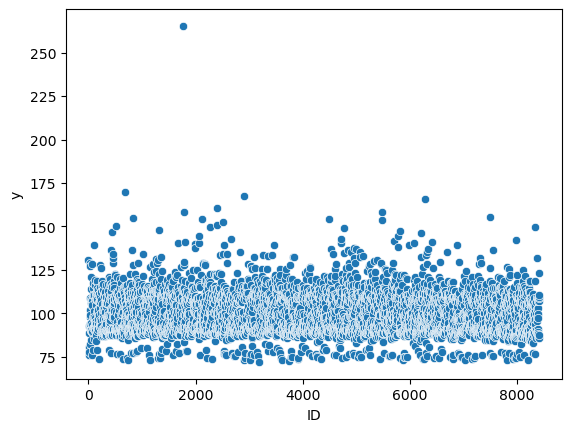

In [205]:
sns.scatterplot(x=benz['ID'], y=benz['y'])

## test

In [162]:
benz_test = pd.read_csv('./Data/benz/test.csv')

In [163]:
# 결측치 확인
benz_test.isnull().sum().sum()

0

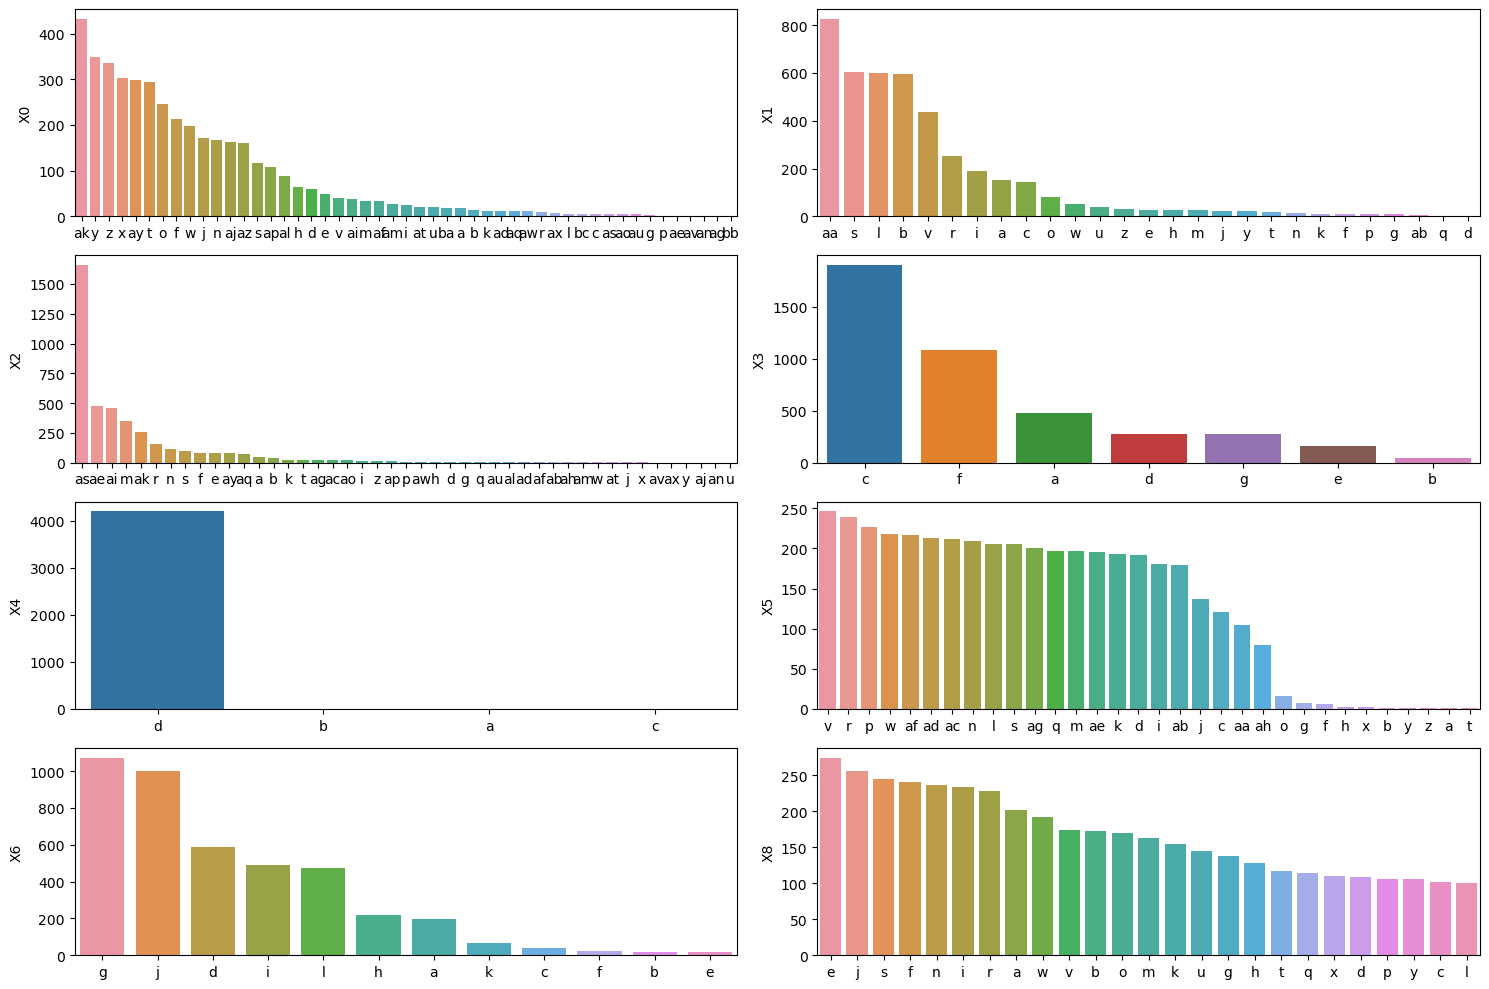

In [164]:
# object type의 column들의 value count
ncol = 2

if len(object_columns)%2 == 0:
    nrow = int(len(object_columns)/2)
else:
    nrow = int(len(object_columns)/2) + 1

fig, axs = plt.subplots(figsize = (15,10),nrows = nrow ,ncols=ncol)

for seq in range(len(object_columns)):
    row = int(seq/ncol)
    col = seq % ncol

    sns.barplot(x=benz_test[object_columns[seq]].value_counts().index, y=benz_test[object_columns[seq]].value_counts(), ax=axs[row, col])

plt.tight_layout()

In [165]:
# object type의 test와 train columns의 values값 비교

print('object')
for ob in object_columns:
    if len(set(benz_test[ob]) - set(benz[ob])) > 0:
        print(ob, set(benz_test[ob]) - set(benz[ob]))

print('\ncategory')
for cate in cate_col:
    if len(set(benz_test[cate]) - set(benz[cate])) > 0 :
        print(cate, set(benz_test[cate]) - set(benz[cate]))

print('\nzero')
for zero in zero_col:
    if len(set(benz_test[zero]) - set(benz[zero])) > 0:
        print(zero, set(benz_test[zero]) - set(benz[zero]))

object
X0 {'p', 'ae', 'an', 'av', 'bb', 'ag'}
X2 {'aj', 'ad', 'u', 'w', 'ab', 'ax'}
X5 {'z', 'a', 'b', 't'}

category

zero
X11 {1}
X93 {1}
X107 {1}
X233 {1}
X235 {1}
X268 {1}
X289 {1}
X290 {1}
X293 {1}
X297 {1}
X330 {1}
X347 {1}


## basic regression

### 필요함수

In [166]:
def one_hot(data, cols):
    oh_encoder = OneHotEncoder()

    oh = oh_encoder.fit_transform(data[cols])
    oh_df = pd.DataFrame(oh.toarray().astype(int), columns=oh_encoder.get_feature_names_out())
    
    return pd.concat([data.drop(cols, axis =1), oh_df], axis=1)

In [167]:
def label(train, test, object_columns):
    train_label = dict()
    test_label = dict()

    for label in object_columns:
        label_encoder = LabelEncoder()
        train_label[label] = label_encoder.fit_transform(train[label])

        for t_label in np.unique(test[label]):
            if t_label not in label_encoder.classes_: # unseen label 데이터인 경우( )
                label_encoder.classes_ = np.append(label_encoder.classes_, t_label)
        
        test_label[label] = label_encoder.transform(test[label])

    train_label_df = pd.concat([train.drop(object_columns, axis=1), pd.DataFrame(train_label)], axis=1)
    test_label_df = pd.concat([test.drop(object_columns, axis=1), pd.DataFrame(test_label)], axis=1)

    return train_label_df, test_label_df

In [168]:
def regression(data, reg):
    X = data.drop(['y'], axis=1)
    y = data.y

    scores = cross_val_score(reg, X, y, scoring='r2', cv=5)

    return np.round(np.mean(scores), 4)

### object type의 변수들만 one hot encoding

In [208]:
train = benz.copy()
test = benz_test.copy()

In [209]:
train = one_hot(train, object_columns)
train.head(1)

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,X8_p,X8_q,X8_r,X8_s,X8_t,X8_u,X8_v,X8_w,X8_x,X8_y
0,0,130.81,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [210]:
lr_reg = LinearRegression()
regression(train, lr_reg)

0.411

### category형식이라고 생각되는 int형 columns 모두 onehotencoding

In [211]:
# int type의 변수들 one hot encoding
category = cate_col.copy()

train = one_hot(train, cate_col)
train.head(1)

,ID,y,X11,X93,X107,X233,X235,X268,X289,X290,...,X380_0,X380_1,X382_0,X382_1,X383_0,X383_1,X384_0,X384_1,X385_0,X385_1
0,0,130.81,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0


In [212]:
lr_reg = LinearRegression()
regression(train, lr_reg)

0.4161

### train data에 0 하나만 존재하는 col 삭제

In [213]:
train = benz.copy()

In [214]:
train = one_hot(train.drop(zero_col, axis=1), object_columns)

In [215]:
lr_reg = LinearRegression()
regression(train, lr_reg)

0.411

In [216]:
train = one_hot(train, cate_col)

In [217]:
lr_reg = LinearRegression()
regression(train, lr_reg)

0.4161

### problem 1 - sol 1) train.csv에는 존재하나 test.csv에는 존재하지 않는 object가 있는 col 삭제

In [179]:
train = benz.copy()
train = train.drop(zero_col, axis = 1)

In [180]:
none_train = list()

for ob in object_columns:
    if len(set(benz_test[ob]) - set(benz[ob])) > 0:
        none_train.append(ob)

train = train.drop(none_train, axis=1)
object_col = object_columns.drop(none_train)

In [181]:
# object type의 변수들 one hot encoding
train = one_hot(train, object_col)

In [182]:
lr_reg = LinearRegression()
regression(train, lr_reg)

0.5106

### problem 1 - sol 2) train.csv와 test.csv를 합쳐 한번에 one hot encoding

In [183]:
test = benz_test.copy()
train = benz.copy()

total = pd.concat([benz, test], ignore_index=True)
total = total.drop(zero_col, axis=1)

In [184]:
# object type의 변수들 one hot encoding 
total = one_hot(total, object_columns)
train = total.iloc[:len(benz)]
test = total.iloc[len(benz):]

In [185]:
lr_reg = LinearRegression()
regression(train, lr_reg)

0.411

### problem 1 - sol 3) label encoding

In [186]:
test = benz_test.copy()
train = benz.copy()

In [187]:
train_label_df, test_label_df = label(train, test, object_columns)

In [188]:
lr_reg = LinearRegression()
regression(train_label_df, lr_reg)

0.5204

### label(object) + one hot encoder(int)

In [189]:
test = benz_test.copy()
train = benz.copy()

train = one_hot(train, cate_col)
test = one_hot(test, cate_col)

In [190]:
train_label_onehot, test_label_onehot = label(train, test, object_columns)

In [191]:
lr_reg = LinearRegression()
regression(train_label_onehot, lr_reg)

0.5204

### * label + boxcox *

In [192]:
label_boxcox = train_label_df.copy()
label_boxcox['y'], maxlog = stats.boxcox(label_boxcox['y'])

lr_reg = LinearRegression()
regression(label_boxcox, lr_reg)

0.6192

### drop + boxcox

In [193]:
train = benz.copy()
train = train.drop(zero_col, axis = 1)

In [194]:
none_train = list()

for ob in object_columns:
    if len(set(benz_test[ob]) - set(benz[ob])) > 0:
        none_train.append(ob)

train = train.drop(none_train, axis=1)
object_col = object_columns.drop(none_train)

In [195]:
# object type의 변수들 one hot encoding
train = one_hot(train, object_col)

In [196]:
train['y'], maxlog = stats.boxcox(train['y'])
lr_reg = LinearRegression()
regression(train, lr_reg)

0.6129

### outlier expected value

In [197]:
label_boxcox = train_label_df.copy()

label_boxcox = label_boxcox[label_boxcox['y'] < 200]

label_boxcox['y'], maxlog = stats.boxcox(label_boxcox['y'])

lr_reg = LinearRegression()
regression(label_boxcox, lr_reg)


0.6214

## 변수 추가 
각 컬럼들의 변수가 무엇을 의미하는지는 알 수 없으나, ID를 제외한 모든 변수들은 사용자 지정 기능을 나타내므로 그 개수가 많을수록 테스트 시간에 영향을 미칠것으로 예상

In [198]:
test = benz_test.copy()
train = benz.copy()

total = pd.concat([benz, test], ignore_index=True)
total = total.drop(zero_col, axis=1)

In [199]:
total['feature_count'] = total.drop(columns=['ID','y'], axis=1).sum(axis = 1)

C:\Users\medici\AppData\Local\Temp\ipykernel_316\2333730819.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  total['feature_count'] = total.drop(columns=['ID','y'], axis=1).sum(axis = 1)


In [200]:
train = total.iloc[:len(train)]
test = total.iloc[len(train):]
test.drop('y', axis=1, inplace=True)
test.reset_index(drop=True, inplace=True)

C:\Users\medici\AppData\Local\Temp\ipykernel_316\4067084490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('y', axis=1, inplace=True)


In [201]:
train_label_df, test_label_df = label(train, test, object_columns)

In [202]:
la_box = train_label_df.copy()

la_box['y'], maxlog = stats.boxcox(la_box['y'])

lr_reg = LinearRegression()
regression(la_box, lr_reg)

0.6189

&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;결론  
1. object columns -> label encoder / drop & one hot
2. target scaler -> box-cox  
3. drop feature -> only zero columns
4. not add feature
5. outlier expected value T/F